Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Missing Values Summary:
Empty DataFrame
Columns: [Missing Values, Percentage]
Index: []
Missing data is likely MAR (Missing at Random) or MNAR (Not Missing at Random)
Missing values handled using mode (categorical) or median (numerical)
Processed data saved at /content/drive/MyDrive/content/processed/cleaned_data.csv

Statistical Summary:
         temperature  electricity_demand          hour           day  \
count  2.895310e+05        2.895310e+05  2.895310e+05  2.895310e+05   
mean   6.596665e-17        2.994022e-17  1.171104e-16  1.256508e-17   
std    1.000002e+00        1.000002e+00  1.000002e+00  1.000002e+00   
min   -2.697425e+00       -9.542250e-01 -1.661754e+00 -1.671481e+00   
25%   -7.828299e-01       -5.914796e-01 -7.949195e-01 -8.767192e-01   
50%   -6.640058e-02       -3.001840e-01  7.191512e-02  3.157961e-02   
75%    7.488465e-01        1.154

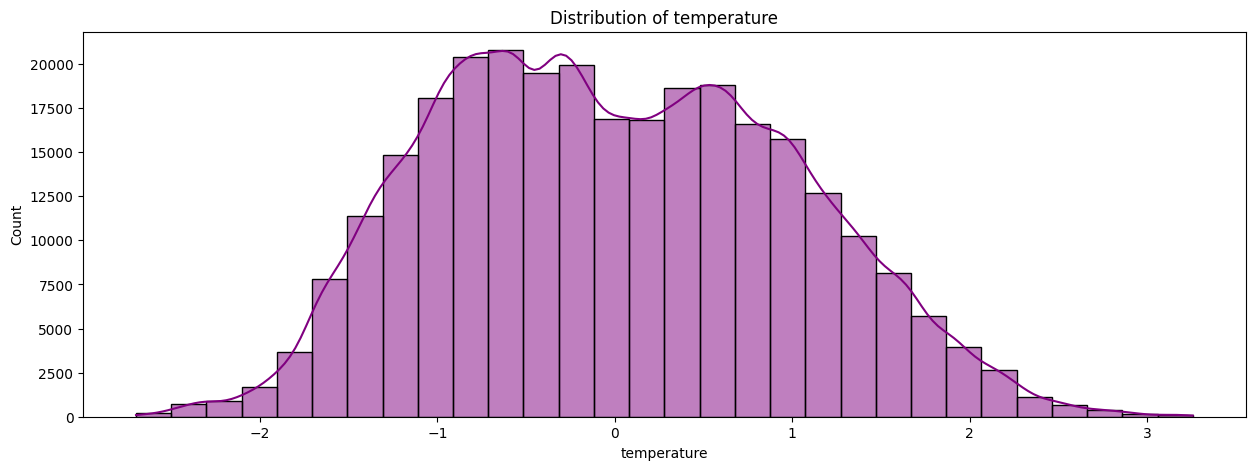

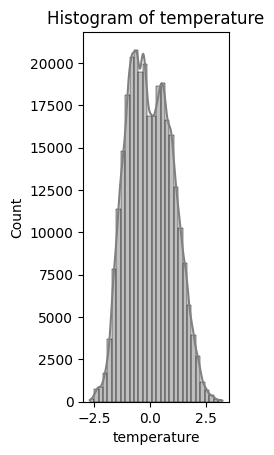

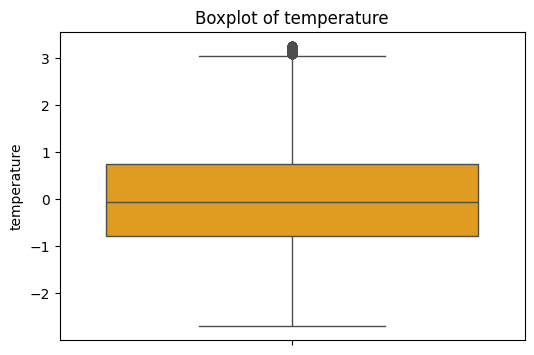

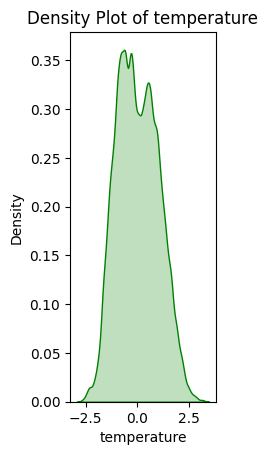

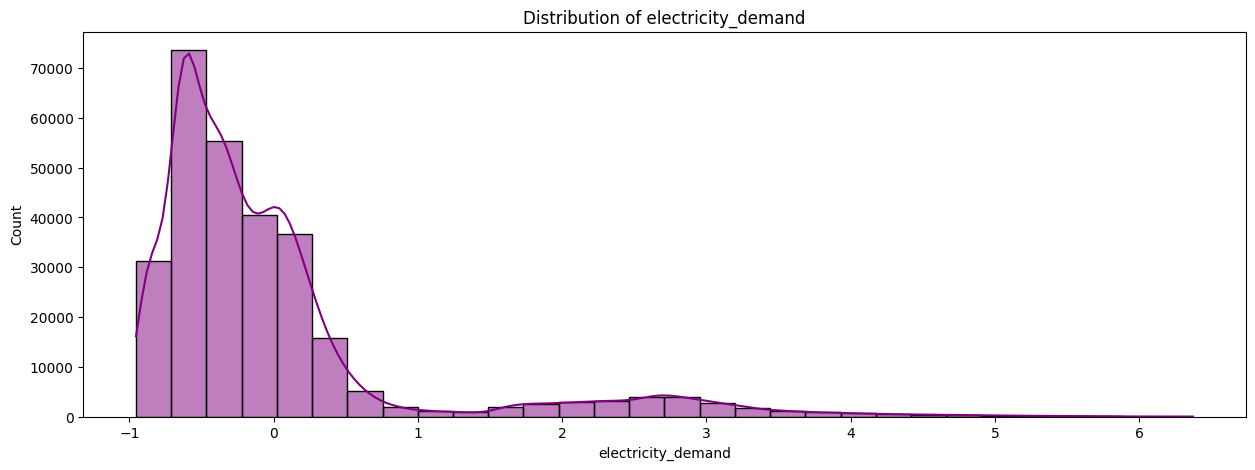

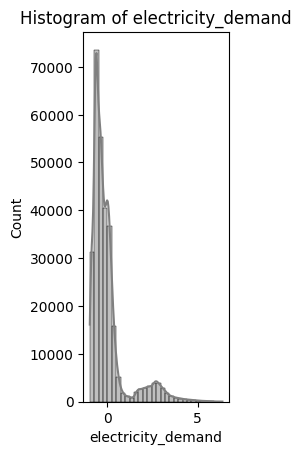

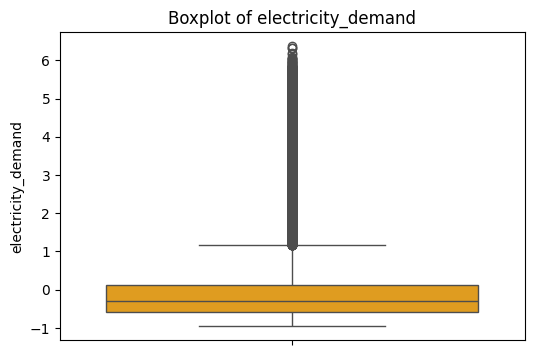

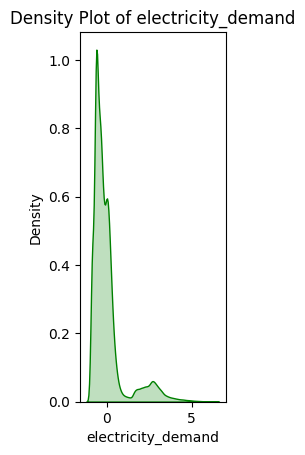

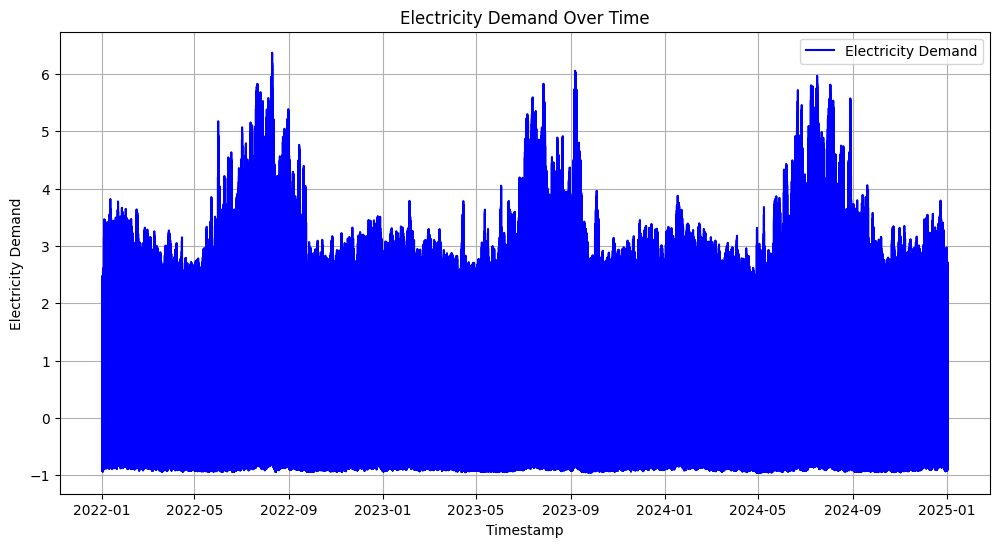

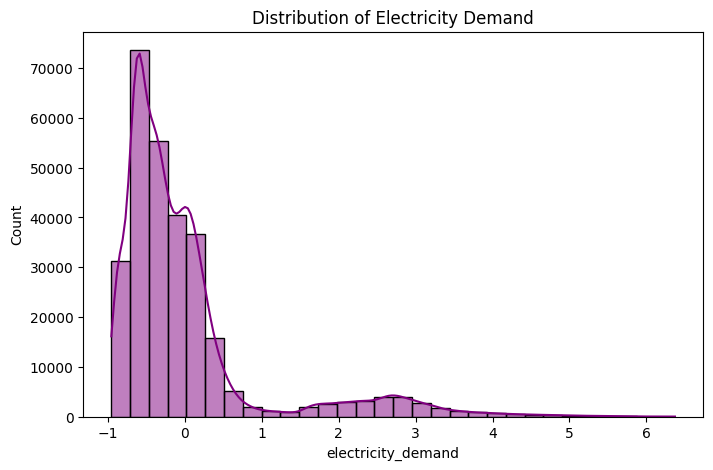

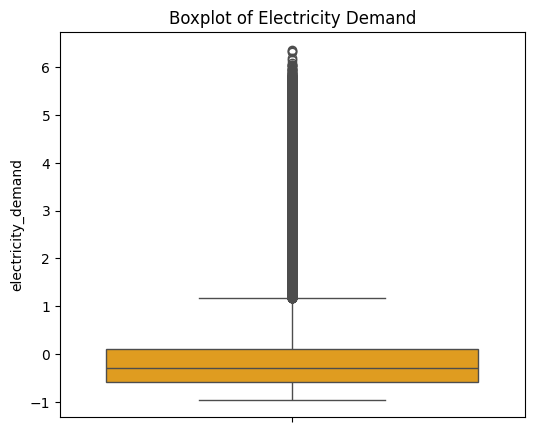

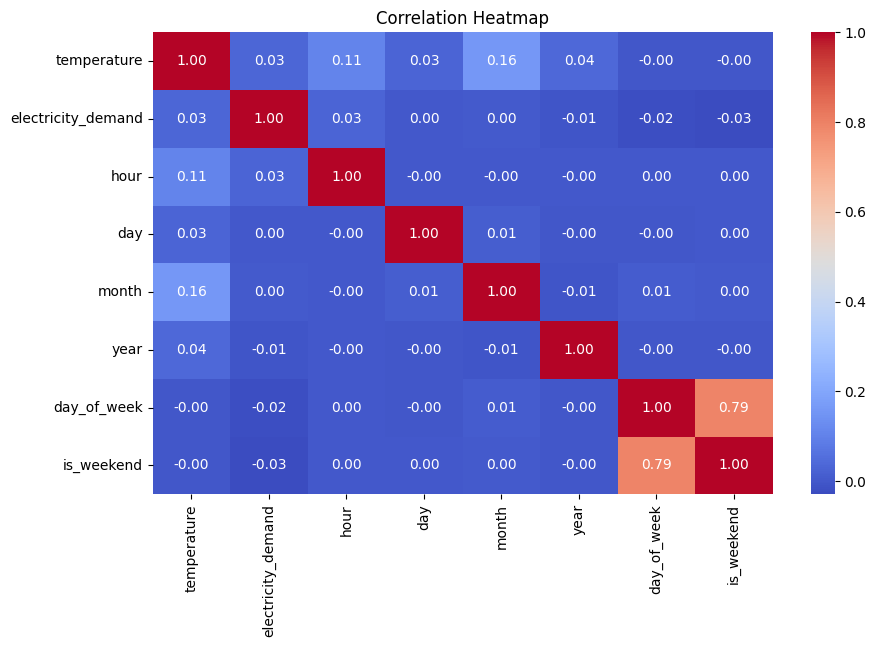

No strong multicollinearity detected.


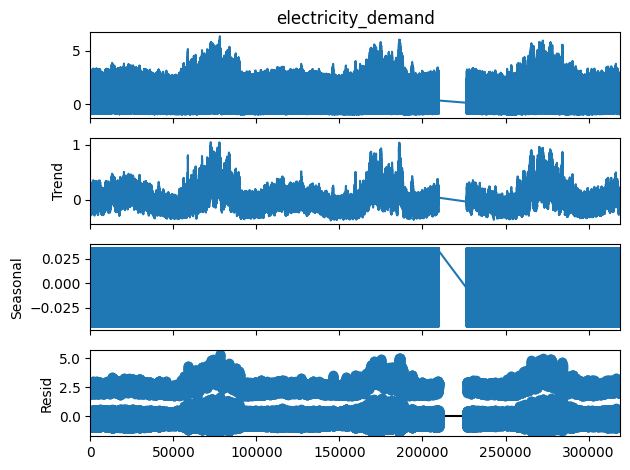

ADF Statistic: -24.364854951127125
p-value: 0.0
Stationary


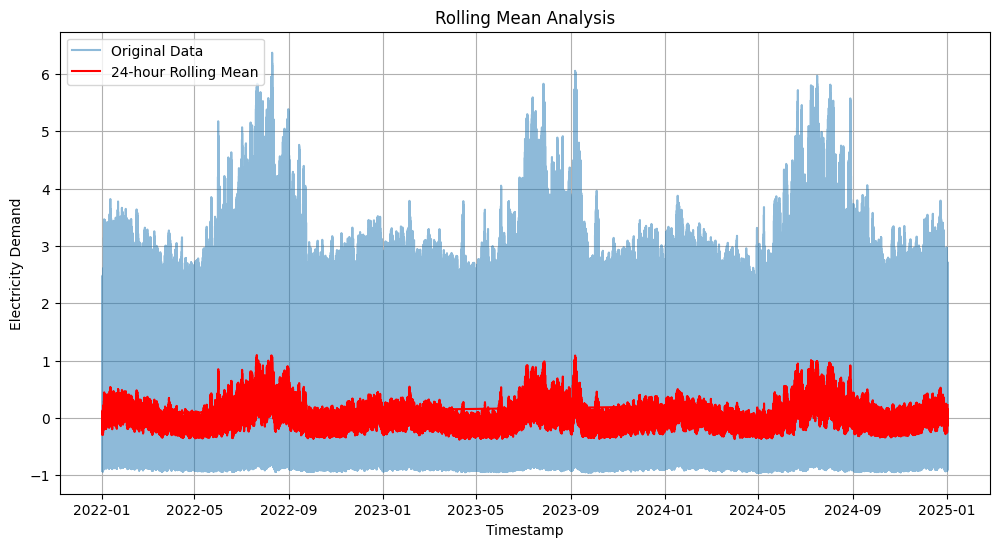


Model Evaluation:
Mean Squared Error (MSE): 0.15509799403984767
Root Mean Squared Error (RMSE): 0.39382482659152873
R-squared Score: 0.0029766156464801075


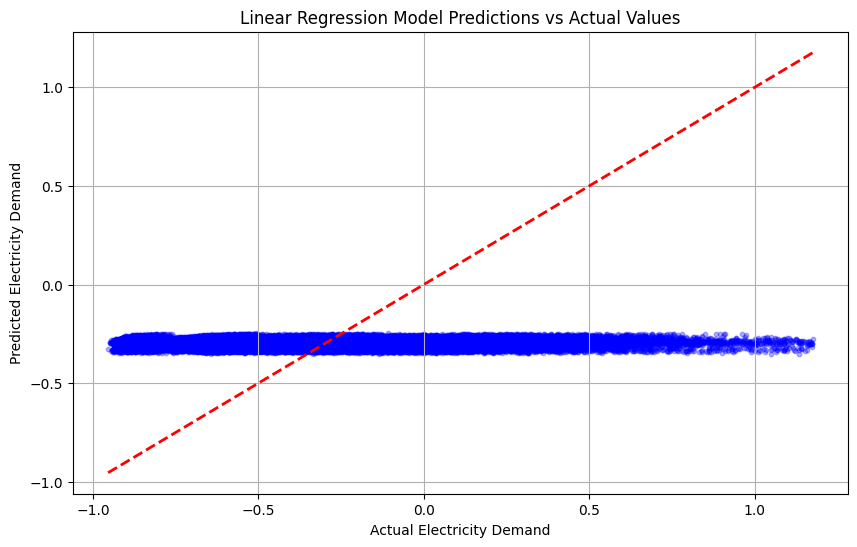

In [5]:
import os
import pandas as pd
import json
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, skew, kurtosis, chi2_contingency
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define file paths
base_path = "/content/drive/MyDrive/content"
weather_dir = os.path.join(base_path, "raw/weather_raw_data")
electricity_dir = os.path.join(base_path, "raw/electricity_raw_data")
save_dir = os.path.join(base_path, "processed")
os.makedirs(save_dir, exist_ok=True)
output_file = os.path.join(save_dir, "cleaned_data.csv")

# Load Weather Data
def load_weather_data(weather_dir):
    weather_data = []
    for file in glob.glob(os.path.join(weather_dir, "*.csv")):
        df = pd.read_csv(file, parse_dates=['date'])
        df.rename(columns={'date': 'timestamp', 'temperature_2m': 'temperature'}, inplace=True)
        weather_data.append(df)
    return pd.concat(weather_data, ignore_index=True) if weather_data else pd.DataFrame()

# Load Electricity Demand Data
def load_electricity_data(electricity_dir):
    electricity_data = []
    for file in glob.glob(os.path.join(electricity_dir, "*.json")):
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)
        if "response" in data and "data" in data["response"]:
            for entry in data["response"]["data"]:
                electricity_data.append({
                    "timestamp": entry["period"],
                    "zone": entry["subba-name"],
                    "electricity_demand": float(entry["value"])
                })
    df = pd.DataFrame(electricity_data)
    df['timestamp'] = pd.to_datetime(df['timestamp'], format="%Y-%m-%dT%H")
    return df

# Data Preprocessing
def preprocess_data(weather_df, electricity_df):
    weather_df['timestamp'] = pd.to_datetime(weather_df['timestamp'], utc=True).dt.tz_convert(None)
    electricity_df['timestamp'] = pd.to_datetime(electricity_df['timestamp'], utc=True).dt.tz_convert(None)
    merged_df = pd.merge(weather_df, electricity_df, on='timestamp', how='inner')
    merged_df.ffill(inplace=True)  # Handle Missing Values
    merged_df.drop_duplicates(inplace=True)  # Remove Duplicates
    return merged_df

# Data Cleaning and Consistency
def data_cleaning_and_consistency(df):
    # Identify missing values
    missing_values = df.isnull().sum()
    missing_percentage = (missing_values / len(df)) * 100
    missing_summary = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percentage})
    print("Missing Values Summary:")
    print(missing_summary[missing_summary['Missing Values'] > 0])

    # Determine if the missingness is MCAR, MAR, or MNAR
    p_value = test_mcar(df)
    if p_value > 0.05:
        print("Missing data is likely MCAR (Missing Completely at Random)")
    else:
        print("Missing data is likely MAR (Missing at Random) or MNAR (Not Missing at Random)")

    # Handling missing data
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            if df[col].dtype == 'object':  # Categorical columns
                df[col].fillna(df[col].mode()[0], inplace=True)  # Impute with mode
            else:  # Numerical columns
                df[col].fillna(df[col].median(), inplace=True)  # Impute with median

    print("Missing values handled using mode (categorical) or median (numerical)")

    # Convert columns to appropriate data types
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df['electricity_demand'] = pd.to_numeric(df['electricity_demand'], errors='coerce')

    # Detect and remove duplicate rows
    df = df.drop_duplicates()

    return df

def test_mcar(df):
    df_miss = df.isnull().astype(int)
    chi2, p, _, _ = chi2_contingency(df_miss.corr())
    return p  # If p > 0.05, data is MCAR

# Feature Engineering
def feature_engineering(data):
    data["hour"] = data["timestamp"].dt.hour
    data["day"] = data["timestamp"].dt.day
    data["month"] = data["timestamp"].dt.month
    data['year'] = data["timestamp"].dt.year
    data["day_of_week"] = data["timestamp"].dt.dayofweek
    data["is_weekend"] = data["day_of_week"].apply(lambda x: 1 if x >= 5 else 0)
    data["season"] = data["month"].apply(lambda x: 'Winter' if x in [12, 1, 2] else 'Spring' if x in [3, 4, 5] else 'Summer' if x in [6, 7, 8] else 'Fall')
    data = pd.get_dummies(data, columns=['season'], drop_first=True)
    return data

# Outlier Detection and Handling
def detect_outliers(df):
    df['z_score'] = zscore(df['electricity_demand'])
    df['outlier_z'] = df['z_score'].abs() > 3
    Q1 = df['electricity_demand'].quantile(0.25)
    Q3 = df['electricity_demand'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound, upper_bound = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    df['outlier_iqr'] = (df['electricity_demand'] < lower_bound) | (df['electricity_demand'] > upper_bound)

    # Handling outliers - Remove extreme outliers while retaining reasonable variations
    df = df[~df['outlier_z'] & ~df['outlier_iqr']]
    return df

# Normalize or standardize numerical features
def normalize_data(data):
    exclude_cols = ['z_score', 'outlier_z', 'outlier_iqr']
    num_cols = [col for col in data.select_dtypes(include=['number']).columns if col not in exclude_cols]
    scaler = StandardScaler()
    data[num_cols] = scaler.fit_transform(data[num_cols])
    return data

# Process Data
def process_data(df):
    df = data_cleaning_and_consistency(df)
    df = feature_engineering(df)
    df = normalize_data(df)
    return df

# Exploratory Data Analysis (Enhanced)
def perform_eda(df):
    numeric_cols = df.select_dtypes(include=['number']).columns
    df[numeric_cols] = df[numeric_cols].astype(float)

    print("\nStatistical Summary:\n", df[numeric_cols].describe())
    print("\nSkewness:\n", df[numeric_cols].apply(skew))
    print("\nKurtosis:\n", df[numeric_cols].apply(kurtosis))

    # Distribution Analysis
    for col in numeric_cols:
      if col in ['temperature', 'electricity_demand']:
        plt.figure(figsize=(15, 5))
        sns.histplot(df[col], bins=30, kde=True, color='purple')
        plt.title(f"Distribution of {col}")
        plt.show()

        plt.subplot(1, 3, 1)
        sns.histplot(df[col], bins=30, kde=True, color='grey')
        plt.title(f"Histogram of {col}")

        plt.figure(figsize=(6, 4))
        sns.boxplot(y=df[col], color='orange')
        plt.title(f"Boxplot of {col}")
        plt.show()

        plt.subplot(1, 3, 3)
        sns.kdeplot(df[col], fill=True, color='green')
        plt.title(f"Density Plot of {col}")
        plt.show()

    # Time Series Analysis
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['electricity_demand'], label='Electricity Demand', color='b')
    plt.xlabel("Timestamp")
    plt.ylabel("Electricity Demand")
    plt.title("Electricity Demand Over Time")
    plt.legend()
    plt.grid()
    plt.show()

    # Univariate Analysis
    plt.figure(figsize=(8, 5))
    sns.histplot(df['electricity_demand'], bins=30, kde=True, color='purple')
    plt.title("Distribution of Electricity Demand")
    plt.show()

    plt.figure(figsize=(6, 5))
    sns.boxplot(y=df['electricity_demand'], color='orange')
    plt.title("Boxplot of Electricity Demand")
    plt.show()

    # Correlation Analysis
    plt.figure(figsize=(10, 6))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()

    # Identify potential multicollinearity issues
    correlation_matrix = df[numeric_cols].corr()
    high_correlation_pairs = [(i, j, correlation_matrix.loc[i, j]) for i in correlation_matrix.columns for j in correlation_matrix.columns if i != j and abs(correlation_matrix.loc[i, j]) > 0.8]
    if high_correlation_pairs:
        print("Potential Multicollinearity Detected in:")
        for i, j, corr_value in high_correlation_pairs:
            print(f"{i} and {j} with correlation of {corr_value:.2f}")
    else:
        print("No strong multicollinearity detected.")

    # Advanced Time Series Techniques
    result = seasonal_decompose(df['electricity_demand'], model='additive', period=24)
    result.plot()
    plt.show()

    # Stationarity Test
    adf_test = adfuller(df['electricity_demand'])
    print(f"ADF Statistic: {adf_test[0]}")
    print(f"p-value: {adf_test[1]}")
    print("Stationary" if adf_test[1] < 0.05 else "Non-Stationary")

    # Rolling Statistics for trend analysis
    df['rolling_mean'] = df['electricity_demand'].rolling(window=24).mean()
    plt.figure(figsize=(12, 6))
    plt.plot(df['timestamp'], df['electricity_demand'], label='Original Data', alpha=0.5)
    plt.plot(df['timestamp'], df['rolling_mean'], label='24-hour Rolling Mean', color='red')
    plt.xlabel("Timestamp")
    plt.ylabel("Electricity Demand")
    plt.title("Rolling Mean Analysis")
    plt.legend()
    plt.grid()
    plt.show()

# Train and Visualize Linear Regression Model
def train_regression(df):
    features = ['hour', 'day_of_week', 'month', 'temperature', 'year', 'is_weekend']
    X = df[features]
    y = df['electricity_demand']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("\nModel Evaluation:")
    print(f"Mean Squared Error (MSE): {mean_squared_error(y_test, y_pred)}")
    print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test, y_pred))}")
    print(f"R-squared Score: {r2_score(y_test, y_pred)}")

    # Regression Visualization with smaller markers
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.3, color='blue', s=10)  # Adjust marker size (s) and transparency (alpha)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='red', linewidth=2)
    plt.xlabel("Actual Electricity Demand")
    plt.ylabel("Predicted Electricity Demand")
    plt.title("Linear Regression Model Predictions vs Actual Values")
    plt.grid()
    plt.show()


# Load data
weather_df = load_weather_data(weather_dir)
electricity_df = load_electricity_data(electricity_dir)

if not weather_df.empty and not electricity_df.empty:
    final_df = preprocess_data(weather_df, electricity_df)
    final_df = process_data(final_df)
    final_df.to_csv(output_file, index=False)
    print(f"Processed data saved at {output_file}")
    perform_eda(final_df)
    final_df = detect_outliers(final_df)
    train_regression(final_df)
else:
    print("No data processed. Check input directories.")
